<a href="https://colab.research.google.com/github/View490/MOTOR_JAPAN/blob/main/ZoneCount_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!nvidia-smi

Thu Nov  9 04:22:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |   2411MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118


In [16]:
import os
HOME = os.getcwd()
print(HOME)

/content/yolov5


In [17]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

In [18]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# from IPython import display
# display.clear_output()

# import detectron2
# print("detectron2:", detectron2.__version__)

In [19]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


In [20]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-9 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 270M/270M [00:02<00:00, 137MB/s]

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients, 209.6 GFLOPs
Adding AutoShape... 


In [30]:
HOME

'/content/yolov5'

In [45]:
MARKET_SQUARE_VIDEO_PATH = f"/content/Kabukicho480p.mp4"

In [61]:
import cv2
from tqdm import tqdm

# Specify the desired output size
new_width = 1920  # Change this to your desired width
new_height = 1080  # Change this to your desired height

# Open the video file
cap = cv2.VideoCapture(MARKET_SQUARE_VIDEO_PATH)

# Create a VideoWriter object to save the resized video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You may need to change the codec
out = cv2.VideoWriter('resized_market_square.mp4', fourcc, 30, (new_width, new_height))

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Use tqdm to display a loading bar
with tqdm(total=total_frames, dynamic_ncols=True, desc="Resizing Video") as pbar:
    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Resize the frame
        frame = cv2.resize(frame, (new_width, new_height))

        # Display or save the frame
        #cv2.imshow('Resized Video', frame)
        out.write(frame)  # Save the frame to the resized video

        pbar.update(1)  # Update the loading bar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the VideoCapture and VideoWriter when done
cap.release()
out.release()
cv2.destroyAllWindows()


Resizing Video: 100%|██████████| 8994/8994 [02:31<00:00, 59.52it/s]


In [67]:
MARKET_SQUARE_VIDEO_PATH = str(HOME)+'/resized_market_square.mp4'

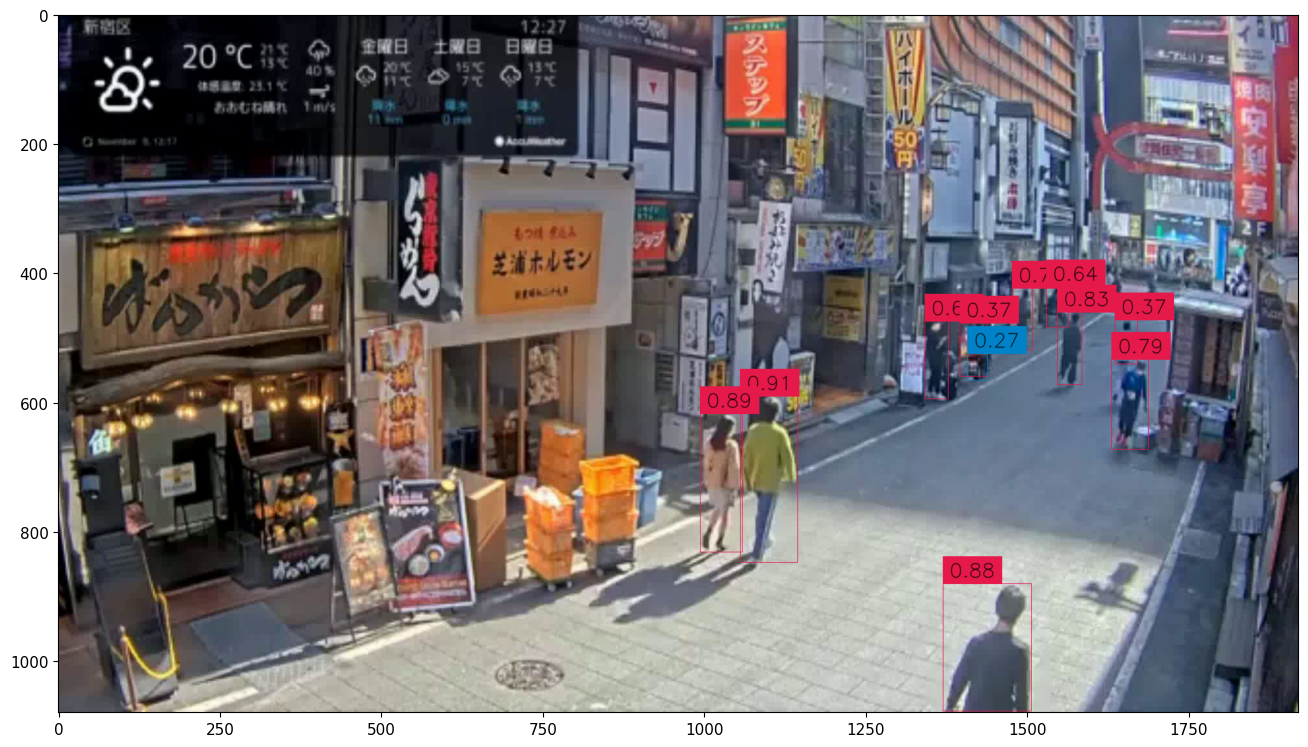

In [68]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

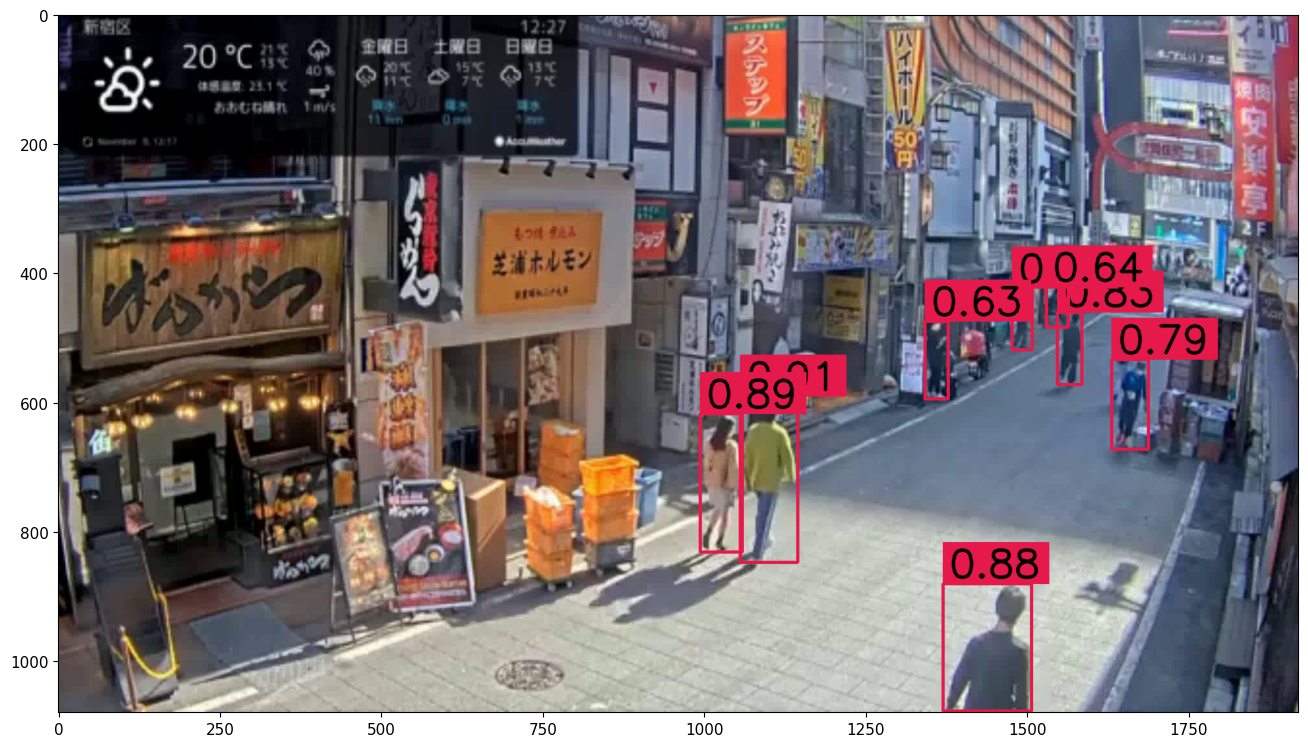

In [69]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [70]:
len(detections)

8

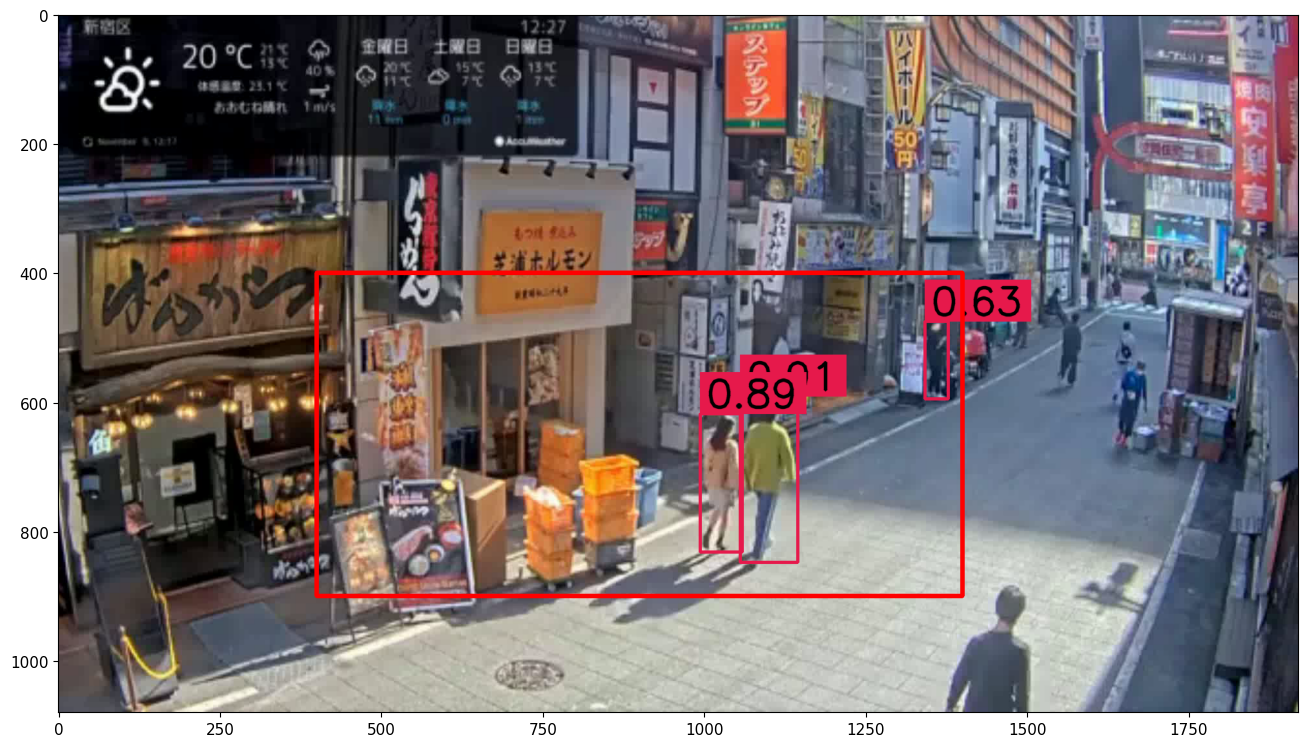

In [96]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [400, 400],
    [1400, 400],
    [1400, 900],
    [400, 900]
])

video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)
mask = zone.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5) & mask]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = sv.draw_polygon(scene=frame, polygon=polygon, color=sv.Color.red(), thickness=6)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [72]:
sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=8994)

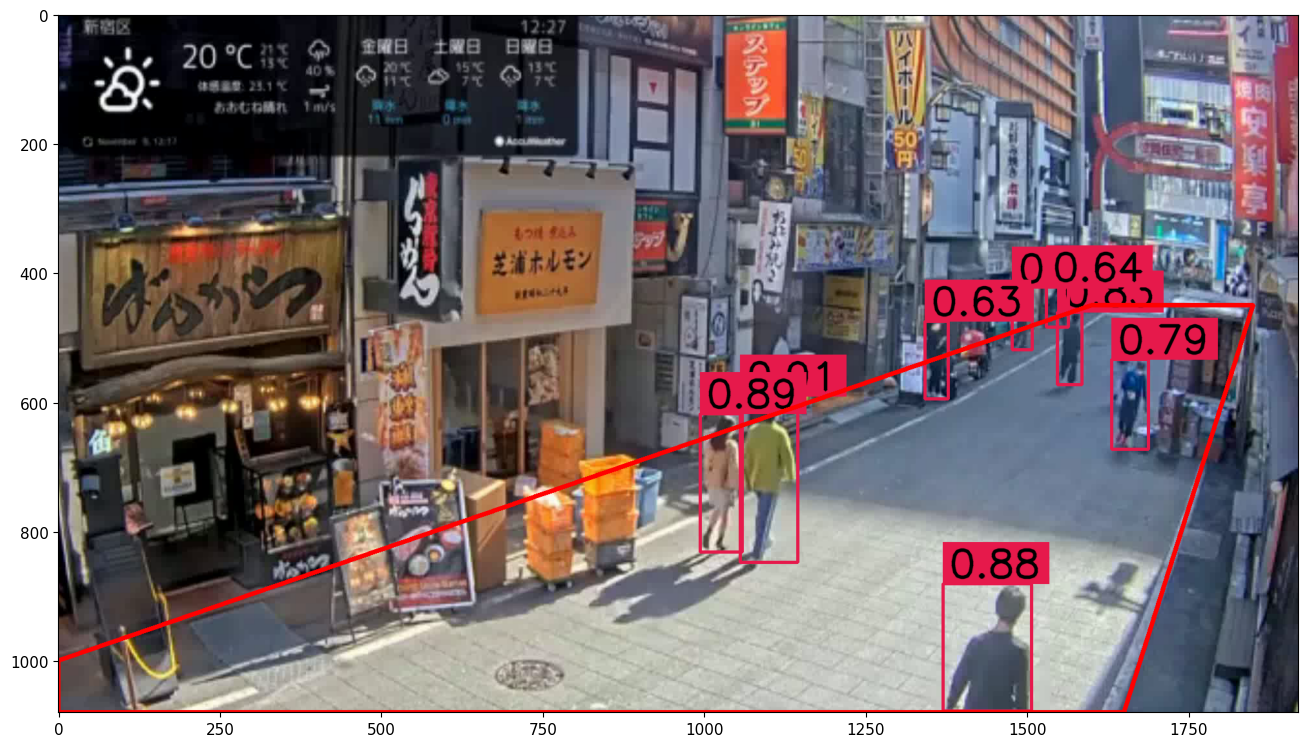

In [114]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [1600, 450],
    [1850, 450],
    [1650, 1080],
    [000, 1080],
    [000, 1000],
])
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)
mask = zone.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5) & mask]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = sv.draw_polygon(scene=frame, polygon=polygon, color=sv.Color.red(), thickness=6)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

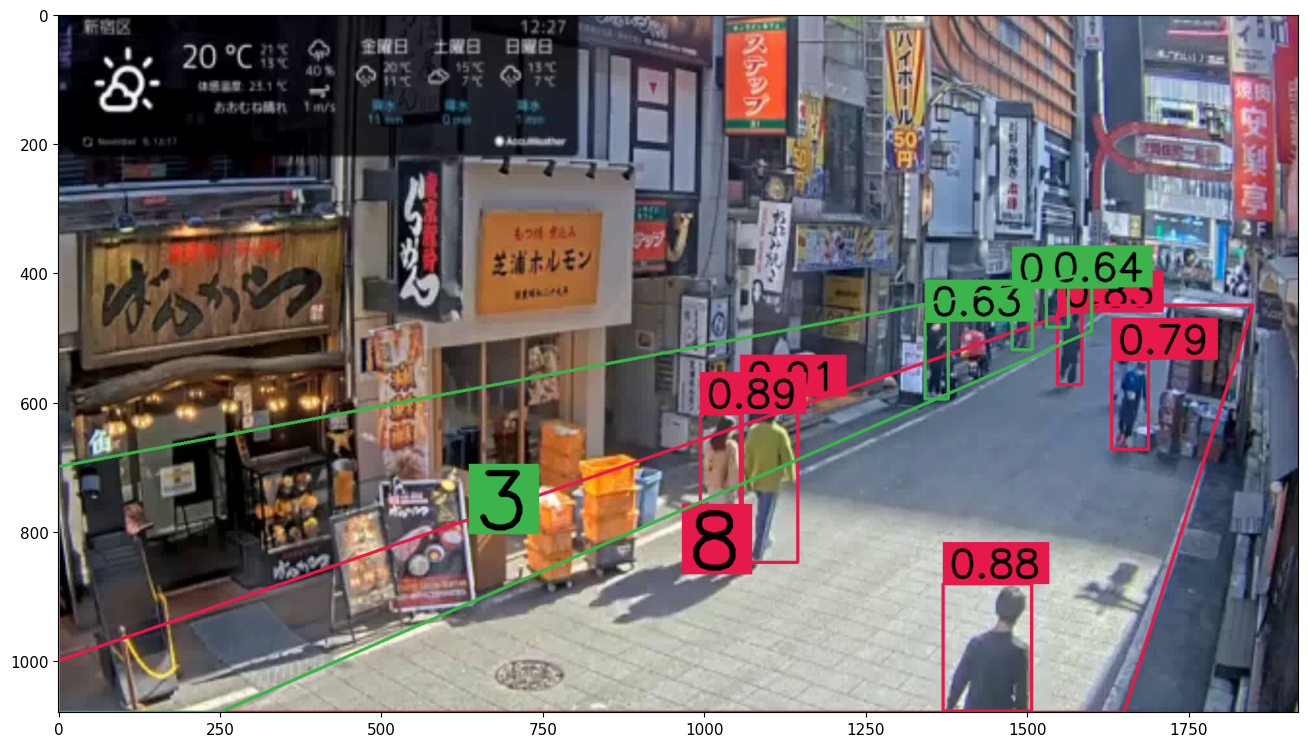

In [127]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [1600, 450],
        [1850, 450],
        [1650, 1080],
        [000, 1080],
        [000, 1000],
    ], np.int32),
    np.array([
        [250,1080],
        [000, 1080],
        [000, 700],
        [1600, 400],
        [1600, 490],
    ], np.int32),
]
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

# extract video frame
generator = sv.get_video_frames_generator(MARKET_SQUARE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=1280)
detections = sv.Detections.from_yolov5(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [130]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [1600, 450],
        [1850, 450],
        [1650, 1080],
        [000, 1080],
        [000, 1000],
    ], np.int32),
    np.array([
        [250,1080],
        [000, 1080],
        [000, 700],
        [1600, 400],
        [1600, 490],
    ], np.int32),
]
video_info = sv.VideoInfo.from_video_path(MARKET_SQUARE_VIDEO_PATH)

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    print(i)
    # detect
    results = model(frame, size=1280)
    detections = sv.Detections.from_yolov5(results)
    detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5)]

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=MARKET_SQUARE_VIDEO_PATH, target_path=f"{HOME}/video-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()